In [1]:
#Others required libraries 
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from prettytable import PrettyTable

#Sklearn 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#tensorflow
import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.keras import optimizers
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D,  Bidirectional, LSTM, concatenate, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
# from keras.optimizers import SGD



#Gensim for word2vec
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
max_length = 200
num_epoch = 50
batch_size = 64
learning_rate = 0.1
decay_rate = learning_rate / num_epoch
momentum = 0.8

In [3]:
training_headline_df = pd.read_csv('../input/reddit-fin-headlines-data/2k_new_labelled.csv')[['sentiment', 'title']]
serving_headline_df = pd.read_csv('../input/reddit-fin-headlines-data/8k-labelled-vader.csv')[['sentiment', 'title']]

kaggle_headline_df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', sep=',', encoding='latin-1',names = ["sentiment","title"])
combined_df = pd.concat([training_headline_df, kaggle_headline_df]).sample(frac=1)

In [4]:
training_headline_df.sentiment.value_counts()

neutral     1037
negative     722
positive     288
Name: sentiment, dtype: int64

In [5]:
kaggle_headline_df.sentiment.value_counts()

neutral     2879
positive    1363
negative     604
Name: sentiment, dtype: int64

In [6]:
combined_df.sentiment.value_counts()

neutral     3916
positive    1651
negative    1326
Name: sentiment, dtype: int64

In [7]:
def plot_sentiment_by_length(headline_df):
    headline_df.loc[headline_df['sentiment'] == 'negative', 'title'].str.len().hist(label = 'negative', alpha=0.5)
    headline_df.loc[headline_df['sentiment'] == 'neutral', 'title'].str.len().hist(label = 'neutral', alpha=0.5)
    headline_df.loc[headline_df['sentiment'] == 'positive', 'title'].str.len().hist(label = 'positive', alpha=0.5)
    plt.title('Balanced Dataset')
    plt.ylabel('Count')
    plt.xlabel('Sentences Length')
    plt.legend()
    plt.savefig('Balanced_Sentiment_Label_By_Sentences_Length.png' , dpi = 300 , transparent = 'true')
    

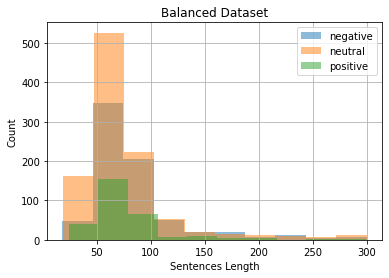

In [8]:
plot_sentiment_by_length(training_headline_df)

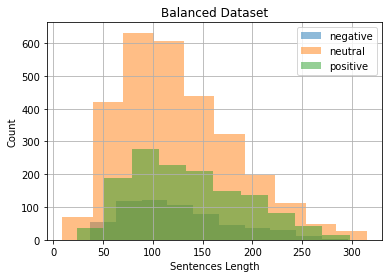

In [9]:
plot_sentiment_by_length(kaggle_headline_df)

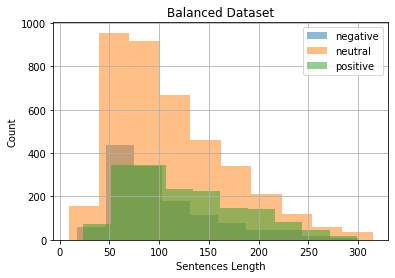

In [10]:
plot_sentiment_by_length(combined_df)

### **Prepare embedding matrix**

In [11]:
tokens = Tokenizer(oov_token = '<OOV>', lower=True, split=' ')
def get_vocab_size(df):
    tokens.fit_on_texts(df['title'].values)
    vocab_size = len(tokens.word_index) + 1
    return vocab_size, tokens
full_df = pd.concat([combined_df, serving_headline_df])
vocab_size, tokens = get_vocab_size(full_df)
vocab_size

19650

In [12]:
w2v_model = KeyedVectors.load_word2vec_format('../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)

In [13]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokens.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(19650, 300)

### **Prepare dataset**

In [14]:
def prepare_data(headline_df):
    headline_df['title'] = headline_df['title'].astype(str)
    encoded_train = tokens.texts_to_sequences(headline_df['title'])
    padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating='post')

    #label encoding
    headline_df['encoded_category'] = LabelEncoder().fit_transform(headline_df['sentiment'])
    y = headline_df["encoded_category"].values
    y = to_categorical(y, num_classes=3)
    
    return padded_train, y

### **Build Model**

In [15]:

def create_model(model_arch, model_name):
    if model_arch == "cnn":
        input_data        = Input(shape = (max_length, ), name = 'Train_Set')
        embedding_layer   = Embedding(vocab_size, 300, weights = [embedding_matrix], trainable = False, name = 'Word2Vec_Embedding')(input_data)
        conv_1            = Conv1D(filters=50, kernel_size=4, activation='relu',name='Convolutional1D_1')(embedding_layer)
        max_1             = MaxPooling1D(pool_size=2,name='MaxPooling_1')(conv_1)
        conv_2            = Conv1D(filters=100, kernel_size=3, activation='relu',name='Convolutional1D_2')(max_1)
        max_2             = MaxPooling1D(pool_size=2,name='MaxPooling_2')(conv_2)
        drop_out          = Dropout(0.2)(max_2)
        flatten           = Flatten(name='Flatten_Layer')(drop_out)
        dense             = Dense(100, activation='relu', name='Fully_Connected_Layer')(flatten)
        out               = Dense(3, activation='softmax',name='Output_Layer')(dense)
        model   = Model(inputs=[input_data], outputs=[out], name = model_name)
    else:
        input_data        = Input(shape = (max_length, ), name = 'Train_Set')
        embedding_layer   = Embedding(vocab_size, 300, name = 'Word2Vec_Embedding')(input_data)
        bi_lstm_1           = Bidirectional(LSTM(32))( embedding_layer)
        drop_out          = Dropout(0.4)(bi_lstm_1)
        out               = Dense(3, activation='softmax',name='Output_Layer')(drop_out)
        model   = Model(inputs=[input_data], outputs=[out], name = model_name)
    
    return model

In [16]:
def recall_m(y_true, y_pred):
        true_positives     = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall             = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives      = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision           = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall    = recall_m(y_true, y_pred)
    return    2*(precision*recall)/(precision+recall+K.epsilon())

In [17]:
def create_callbacks(model_name):
    reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                                  mode = 'max', 
                                  factor=0.5, 
                                  patience=5, 
                                  min_lr=0.0001, 
                                  verbose=10)

    checkpoint = ModelCheckpoint(f"{model_name}_training.h5", 
                                   monitor="val_loss", 
                                   mode="min", 
                                   save_best_only = True, 
                                   verbose=1)

    earlystop = EarlyStopping(monitor = 'val_loss', 
                                mode="min", 
                                min_delta = 0, 
                                patience = 5,
                                verbose=1)
    callbacks = [reduce_lr, checkpoint, earlystop]
    return callbacks

In [18]:
def training(model, model_arch, model_name, model_weight = None, sgd = False):
    # class weight
    if model_arch == "cnn":
        y_ = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight('balanced', np.unique(y_), y_)
        d_class_weights = dict(enumerate(class_weights))
    else:
        d_class_weights = None
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    if sgd:
        opt = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    
    if model_weight:
        model.load_weights(model_weight)

    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[f1_m, 'acc', precision_m, recall_m])
    history = model.fit(X_train, y_train,
                        class_weight = d_class_weights, 
                        batch_size=batch_size, 
                        epochs=num_epoch, 
                        verbose=1, 
                        callbacks=create_callbacks(model_name), 
                        validation_data=(X_val, y_val))
    model.save(f"{model_arch}_{model_name}.h5")
    return model, history

### Utilities

In [19]:
def plot_curve(history, model_name):
    # acc
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    # plt.ylim([0.7, 0.8])
    plt.legend(['train','Validation'], loc='upper left')
    plt.savefig(f'{model_name}_Accuracy.png' , dpi = 300 , transparent = 'true')
    plt.show()

    # precision
    plt.plot(history.history['precision_m'][1:])
    plt.plot(history.history['val_precision_m'][1:])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epochs')
    # plt.ylim([0.7, 0.8])
    plt.legend(['train','Validation'], loc='upper left')
    plt.savefig(f'{model_name}_Precision.png' , dpi = 300 , transparent = 'true')
    plt.show()

    # f1
    plt.plot(history.history['f1_m'][1:])
    plt.plot(history.history['val_f1_m'][1:])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epochs')
    # plt.ylim([0.7, 0.8])
    plt.legend(['train','Validation'], loc='upper left')
    plt.savefig(f'{model_name}_F1Score.png' , dpi = 300 , transparent = 'true')
    plt.show()

    # loss
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    # plt.ylim([0.5, 0.6])
    plt.legend(['train','Validation'], loc='upper left')
    plt.savefig(f'{model_name}_Loss.png' , dpi = 300 , transparent = 'true')
    plt.show()

    # recall
    plt.plot(history.history['recall_m'][1:])
    plt.plot(history.history['val_recall_m'][1:])
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epochs')
    # plt.ylim([0.7, 0.8])
    plt.legend(['train','Validation'], loc='upper left')
    plt.savefig(f'{model_name}_Recall.png' , dpi = 300 , transparent = 'true')
    plt.show()


In [20]:
def plot_metric(score):
    pretty_table = PrettyTable()
    pretty_table.field_names = ['Parameters','Value']
    pretty_table.add_row(['Loss Score'                     ,score[0]])
    pretty_table.add_row(['F1 Score'                       ,score[1]])
    pretty_table.add_row(['Accuracy Score'                 ,score[2]])
    pretty_table.add_row(['Recall Score'                   ,score[3]])
    pretty_table.add_row(['Precision Score'                ,score[4]])

    print(pretty_table)

## Start doing

We consider 4 scenarios as follows:
* Start training only on Kaggle dataset
* Start training only on crawled dataset
* Transfer learning from Kaggle to crawled dataset
* Combine 2 datasets

In [21]:
from sklearn.utils.class_weight import compute_class_weight

In [22]:
model_data = {
    "train_on_kg": kaggle_headline_df,
    "train_on_reddit": training_headline_df,
    "transfer_learning_on_reddit": training_headline_df,
    "combined_data": combined_df 
}
models = ['cnn', 'lstm']

Training cnn by 4 training methods
---------------------------------------------------
Start training for train_on_kg



User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

Model: "train_on_kg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          5895000   
_________________________________________________________________
Convolutional1D_1 (Conv1D)   (None, 197, 50)           60050     
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 98, 50)            0         
_________________________________________________________________
Convolutional1D_2 (Conv1D)   (None, 96, 100)           15100     
_________________________________________________________________
MaxPooling_2 (MaxPooling1D)  (None, 48, 100)           0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 100)           

2022-11-02 17:09:46.443969: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
62/62 [==============================] - 6s 78ms/step - loss: 1.0332 - f1_m: 0.1748 - acc: 0.4534 - precision_m: 0.3499 - recall_m: 0.1300 - val_loss: 1.0338 - val_f1_m: 0.3642 - val_acc: 0.4668 - val_precision_m: 0.5163 - val_recall_m: 0.2819

Epoch 00001: val_loss improved from inf to 1.03380, saving model to train_on_kg_training.h5
Epoch 2/50
62/62 [==============================] - 4s 69ms/step - loss: 0.8433 - f1_m: 0.5347 - acc: 0.6019 - precision_m: 0.6597 - recall_m: 0.4581 - val_loss: 0.9469 - val_f1_m: 0.3525 - val_acc: 0.5286 - val_precision_m: 0.6124 - val_recall_m: 0.2497

Epoch 00002: val_loss improved from 1.03380 to 0.94693, saving model to train_on_kg_training.h5
Epoch 3/50
62/62 [==============================] - 4s 71ms/step - loss: 0.6644 - f1_m: 0.6628 - acc: 0.6888 - precision_m: 0.7220 - recall_m: 0.6205 - val_loss: 1.0087 - val_f1_m: 0.5213 - val_acc: 0.5309 - val_precision_m: 0.5400 - val_recall_m: 0.5044

Epoch 00003: val_loss did not improve from 0

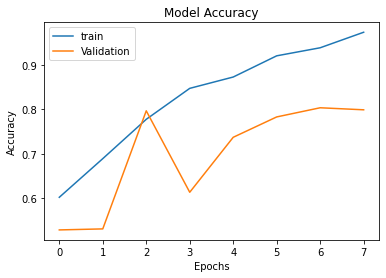

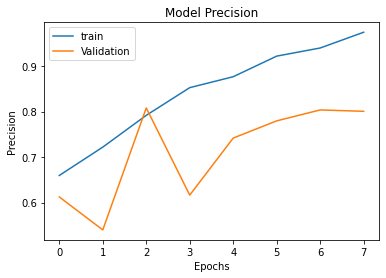

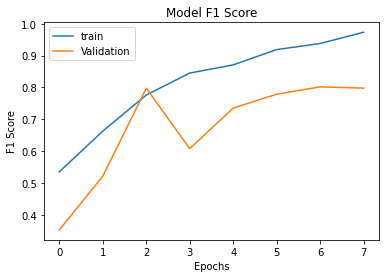

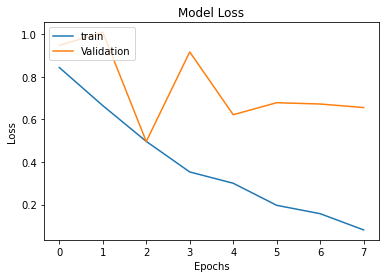

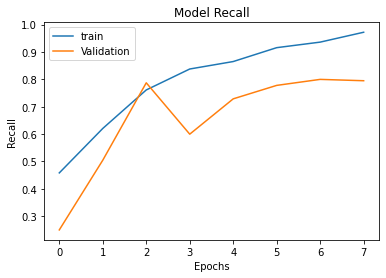

Confusion Matrix
Finish train_on_kg
---------------------------------------------------
---------------------------------------------------
Start training for train_on_reddit
Model: "train_on_reddit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          5895000   
_________________________________________________________________
Convolutional1D_1 (Conv1D)   (None, 197, 50)           60050     
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 98, 50)            0         
_________________________________________________________________
Convolutional1D_2 (Conv1D)   (None, 96, 100)           15100     
_________________________________________________________________
MaxPooli

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[0 1 1 ... 2 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/50
26/26 [==============================] - 3s 97ms/step - loss: 1.1002 - f1_m: 0.0000e+00 - acc: 0.3150 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0871 - val_f1_m: 0.0000e+00 - val_acc: 0.5081 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.08711, saving model to train_on_reddit_training.h5
Epoch 2/50
26/26 [==============================] - 2s 72ms/step - loss: 1.0595 - f1_m: 0.0391 - acc: 0.4158 - precision_m: 0.3114 - recall_m: 0.0217 - val_loss: 0.9537 - val_f1_m: 0.2894 - val_acc: 0.6054 - val_precision_m: 0.8354 - val_recall_m: 0.1764

Epoch 00002: val_loss improved from 1.08711 to 0.95366, saving model to train_on_reddit_training.h5
Epoch 3/50
26/26 [==============================] - 2s 68ms/step - loss: 0.9879 - f1_m: 0.3467 - acc: 0.5214 - precision_m: 0.6383 - recall_m: 0.2457 - val_loss: 0.9014 - val_f1_m: 0.4455 - val_acc: 0.5946 - val_precision_m: 0.7271 - val_recall_m: 0.3227

Epoch 00003:

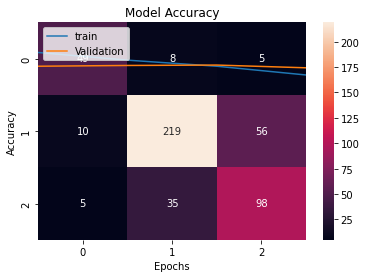

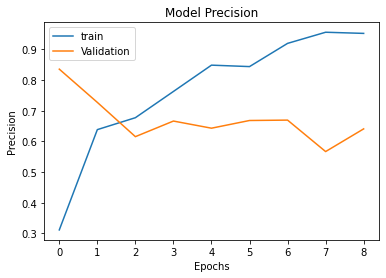

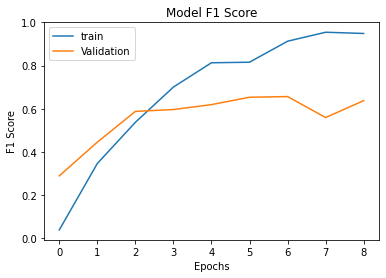

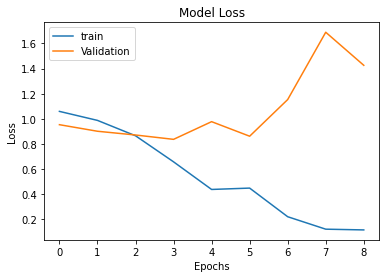

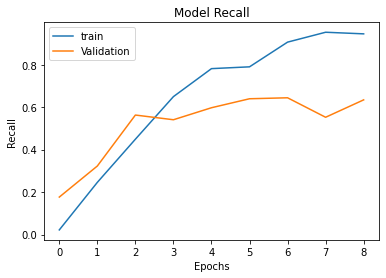

Confusion Matrix
Finish train_on_reddit
---------------------------------------------------
---------------------------------------------------
Start training for transfer_learning_on_reddit
Model: "transfer_learning_on_reddit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          5895000   
_________________________________________________________________
Convolutional1D_1 (Conv1D)   (None, 197, 50)           60050     
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 98, 50)            0         
_________________________________________________________________
Convolutional1D_2 (Conv1D)   (None, 96, 100)           15100     
______________________________________________

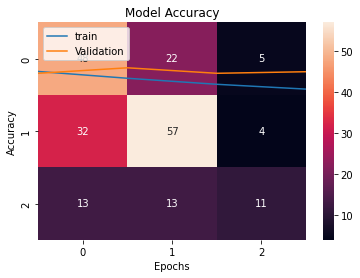

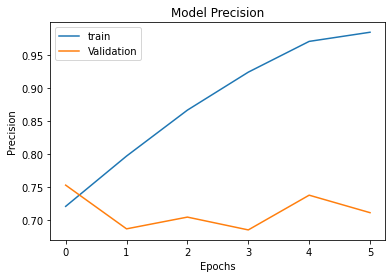

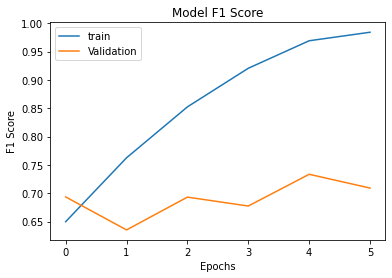

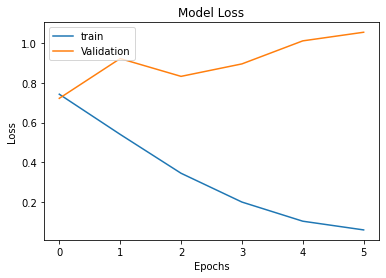

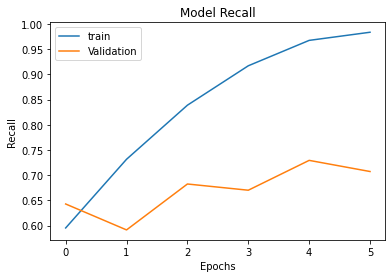

Confusion Matrix
Finish transfer_learning_on_reddit
---------------------------------------------------
---------------------------------------------------
Start training for combined_data
Model: "combined_data"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          5895000   
_________________________________________________________________
Convolutional1D_1 (Conv1D)   (None, 197, 50)           60050     
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 98, 50)            0         
_________________________________________________________________
Convolutional1D_2 (Conv1D)   (None, 96, 100)           15100     
______________________________________________________________

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[1 0 1 ... 1 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


88/88 [==============================] - 7s 69ms/step - loss: 1.0127 - f1_m: 0.1952 - acc: 0.4656 - precision_m: 0.3552 - recall_m: 0.1519 - val_loss: 0.9246 - val_f1_m: 0.4866 - val_acc: 0.5636 - val_precision_m: 0.6114 - val_recall_m: 0.4057

Epoch 00001: val_loss improved from inf to 0.92462, saving model to combined_data_training.h5
Epoch 2/50
88/88 [==============================] - 6s 69ms/step - loss: 0.7772 - f1_m: 0.6140 - acc: 0.6460 - precision_m: 0.6787 - recall_m: 0.5642 - val_loss: 0.7059 - val_f1_m: 0.6985 - val_acc: 0.7118 - val_precision_m: 0.7507 - val_recall_m: 0.6538

Epoch 00002: val_loss improved from 0.92462 to 0.70594, saving model to combined_data_training.h5
Epoch 3/50
88/88 [==============================] - 6s 67ms/step - loss: 0.6033 - f1_m: 0.7256 - acc: 0.7361 - precision_m: 0.7562 - recall_m: 0.6984 - val_loss: 0.6491 - val_f1_m: 0.7225 - val_acc: 0.7279 - val_precision_m: 0.7396 - val_recall_m: 0.7062

Epoch 00003: val_loss improved from 0.70594 to 0.64

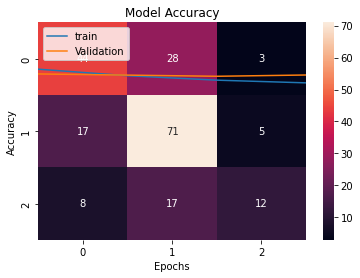

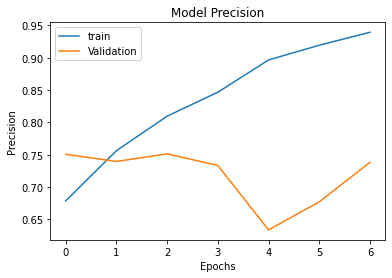

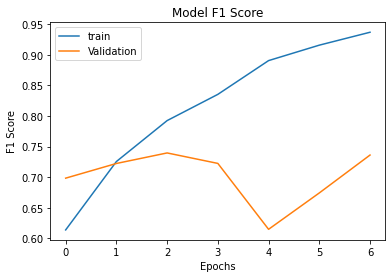

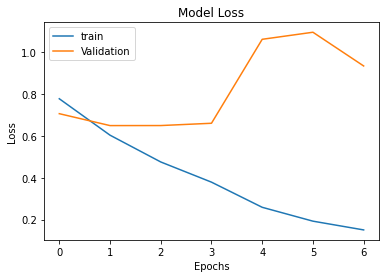

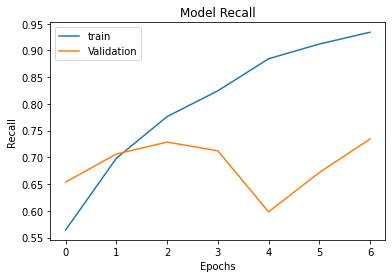

Confusion Matrix
Finish combined_data
---------------------------------------------------
Training lstm by 4 training methods
---------------------------------------------------
Start training for train_on_kg
Model: "train_on_kg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          5895000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output_Layer (Dense)         (None, 3)                 195       
Total params: 5,980,443
Trainable params: 5,

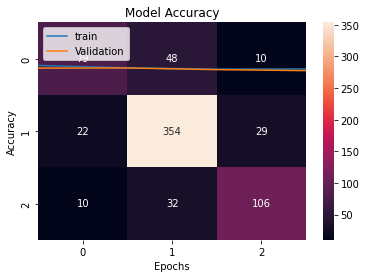

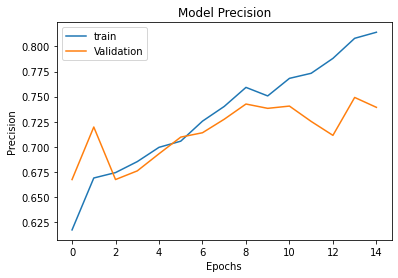

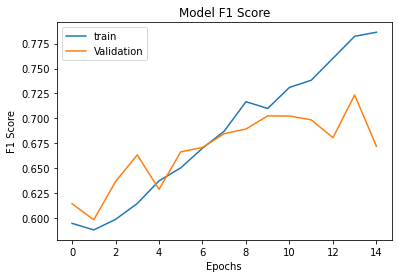

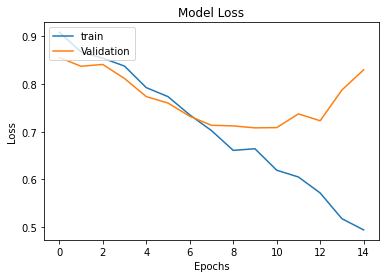

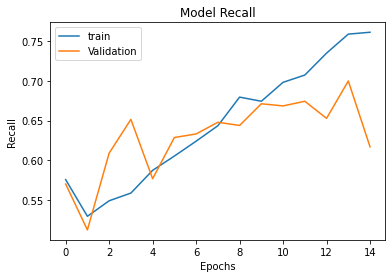

Confusion Matrix
Finish train_on_kg
---------------------------------------------------
---------------------------------------------------
Start training for train_on_reddit
Model: "train_on_reddit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          5895000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output_Layer (Dense)         (None, 3)                 195       
Total params: 5,980,443
Trainable params: 5,980,443
Non-trainable params: 

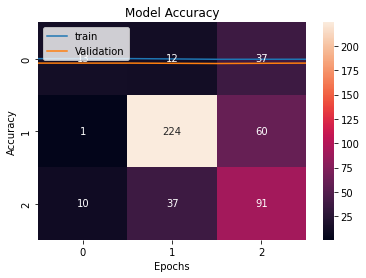

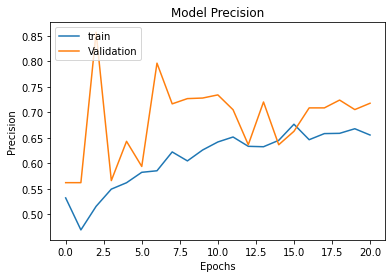

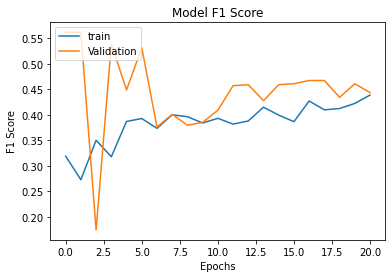

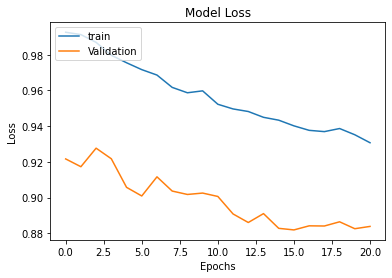

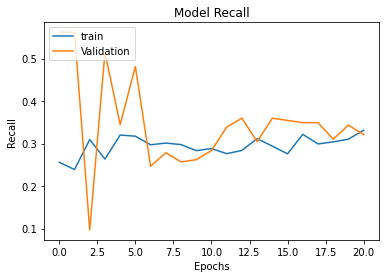

Confusion Matrix
Finish train_on_reddit
---------------------------------------------------
---------------------------------------------------
Start training for transfer_learning_on_reddit
Model: "transfer_learning_on_reddit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          5895000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output_Layer (Dense)         (None, 3)                 195       
Total params: 5,980,443
Trainable params: 5,98

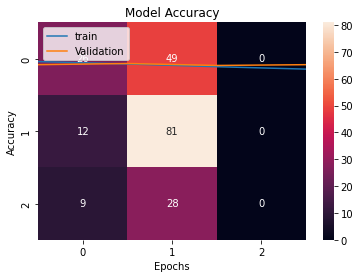

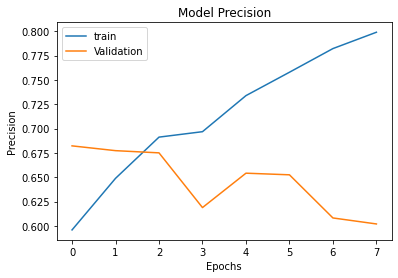

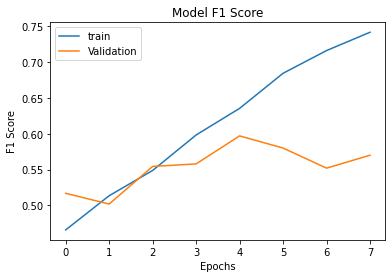

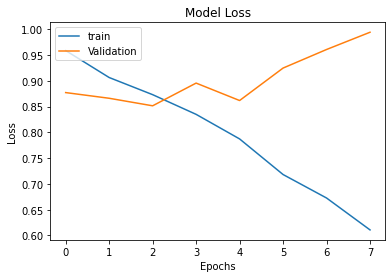

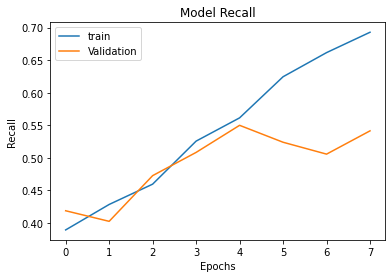

Confusion Matrix
Finish transfer_learning_on_reddit
---------------------------------------------------
---------------------------------------------------
Start training for combined_data
Model: "combined_data"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_Set (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
Word2Vec_Embedding (Embeddin (None, 200, 300)          5895000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output_Layer (Dense)         (None, 3)                 195       
Total params: 5,980,443
Trainable params: 5,980,443
Non-traina

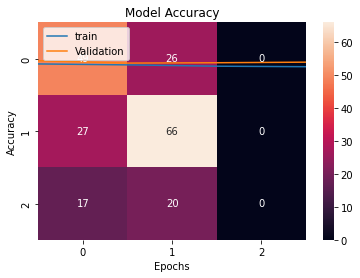

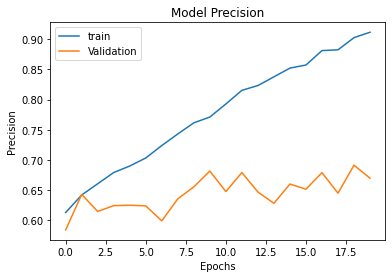

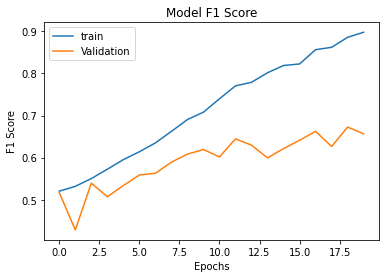

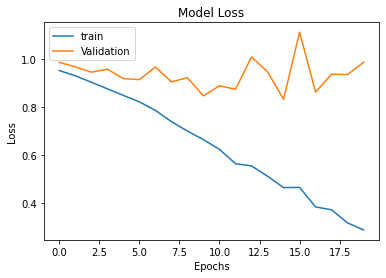

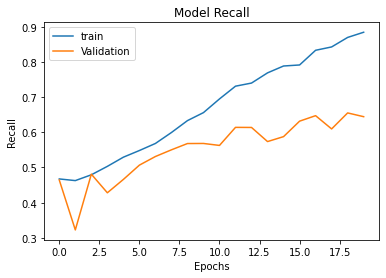

Confusion Matrix
Finish combined_data
---------------------------------------------------


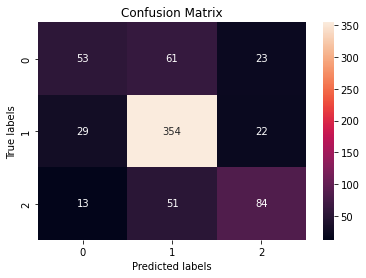

In [23]:
for model_arch in models:
    print(f"Training {model_arch} by 4 training methods")
    for model_name in model_data:
        print("---------------------------------------------------")
        print(f"Start training for {model_name}")
        df = model_data[model_name]
        padded_train, y = prepare_data(df)
        X_train, X_test, y_train, y_test = train_test_split(padded_train, y, test_size = 0.1, random_state = 1)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 1)
        model = create_model(model_arch, model_name)
        print(model.summary())
        if model_name == "transfer_learning_on_reddit":
            model_weight = f"{model_arch}_train_on_kg.h5"
        else:
            model_weight = None
        model, history = training(model, model_arch, model_name, model_weight, True)
        score = model.evaluate(X_test, y_test)
        print("---------------------------------------------------")
        print("Test Metric")
        plot_metric(score)

        print("Plot training curve")
        plot_curve(history, model_name)
        print("Confusion Matrix")
        cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
        labels = [0,1,2]
        ax= plt.subplot()
        # labels, title and ticks
        sns.heatmap(cnf_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        print(f"Finish {model_name}")
        print("---------------------------------------------------")

# Test

In [24]:
def prep_serving_data(headline_df):
    le = LabelEncoder()
    le.fit_transform(headline_df['title'])
    vocab_size, tokens = get_vocab_size(headline_df)
    headline_df['title'] = headline_df['title'].astype(str)
    encoded_train = tokens.texts_to_sequences(headline_df['title'])
    padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating='post')
    
    return le, padded_train

In [25]:
def get_pred(model_name):
    cnn_weight = f"./cnn_{model_name}.h5"
    lstm_weight = f"./lstm_{model_name}.h5"

    cnn_model = create_model("cnn", f"cnn_serving_{model_name}")
    cnn_model.load_weights(cnn_weight)
    cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=[f1_m, 'acc', precision_m, recall_m])
    cnn_preds = cnn_model.predict(X_test)

    lstm_model = create_model("lstm", f"lstm_serving_{model_name}")
    lstm_model.load_weights(lstm_weight)
    lstm_model.compile(optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False), loss='categorical_crossentropy', metrics=[f1_m, 'acc', precision_m, recall_m])
    lstm_preds = lstm_model.predict(X_test)
    
    return (cnn_preds, lstm_preds)

In [26]:
def get_full_df_metric(X_test, preds):
    le = LabelEncoder()
    le.fit_transform(serving_headline_df['sentiment'])
    preds = preds.argmax(axis=-1)
    submission = pd.DataFrame()
    submission['title'] = tokens.sequences_to_texts(X_test)
    submission['prediction'] = le.inverse_transform(preds)
    submission['sentiment'] = serving_headline_df['sentiment']
    return submission

In [27]:
df_dict = {}

In [28]:
for model_name in model_data:
    print("---------------------------------------------------")
    print(f"Start serving for {model_name} using serving-data")

    le, X_test = prep_serving_data(serving_headline_df)
    (cnn_preds, lstm_preds) = get_pred(model_name)
    print("---------------------------------------------------")
    print(f"Submission for cnn_{model_name}")
    cnn_submission = get_full_df_metric(X_test, cnn_preds)
    print(f"Submission for lstm_{model_name}")
    lstm_submission = get_full_df_metric(X_test, lstm_preds)
    
    df_dict[f'cnn_{model_name}'] = cnn_submission
    df_dict[f'lstm_{model_name}'] = lstm_submission
    cnn_submission.to_csv(f'cnn_{model_name}_serving.csv', index=False)
    lstm_submission.to_csv(f'lstm_{model_name}_serving.csv', index=False)
    
    print(f"Finish {model_name}")
    print("---------------------------------------------------")

---------------------------------------------------
Start serving for train_on_kg using serving-data
---------------------------------------------------
Submission for cnn_train_on_kg
Submission for lstm_train_on_kg
Finish train_on_kg
---------------------------------------------------
---------------------------------------------------
Start serving for train_on_reddit using serving-data
---------------------------------------------------
Submission for cnn_train_on_reddit
Submission for lstm_train_on_reddit
Finish train_on_reddit
---------------------------------------------------
---------------------------------------------------
Start serving for transfer_learning_on_reddit using serving-data
---------------------------------------------------
Submission for cnn_transfer_learning_on_reddit
Submission for lstm_transfer_learning_on_reddit
Finish transfer_learning_on_reddit
---------------------------------------------------
---------------------------------------------------
Start s

# Ensemble 

## Model selection

In [29]:
combos = [(1, 0), (0, 1), (0.5, 0.5), (0.25, 0.75), (0.1, 0.9), (0.3, 0.7), (0.4, 0.6), (0.2, 0.8), (0.15, 0.85), (0.05, 0.95)]

In [30]:
def ensemble(combos, pred_lists):
    highest_f1 = 0
    for combo in combos:
        w1, w2 = combo
        ensemble_pred = w1 * pred_lists[0] + w2 * pred_lists[1]

        class_list = []
        for i in range(0, ensemble_pred.shape[0]):
            y_class = ensemble_pred[i, :].argmax(axis=-1)
            class_list += [y_class]

        submission = pd.DataFrame()
        submission['title'] = tokens.sequences_to_texts(X_test)
        submission['prediction'] = le.inverse_transform(class_list)
        submission['sentiment'] = le.inverse_transform(y_test.argmax(axis=-1).tolist())
        preds = submission['prediction'].to_list()
        labels = submission['sentiment'].to_list()
        acc = accuracy_score(labels,preds) 
        f1 = f1_score(labels,preds, average='micro') 

        if f1 > highest_f1:
            highest_f1 = f1
            submission.to_csv(f'cnn_lstm_{w1}_{w2}_submission.csv', index=False)
            print(f"Combo of cnn_lstm_{w1}_{w2} with acc {acc:.2f} and f1 {f1:.2f}")